In [1]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# # The GPU id to use, usually either "0" or "1"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Import Packages

In [2]:
import numpy as np
import keras
import cv2
import pandas as pd
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, GRU, Flatten,Merge
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
import os
import tensorflow as tf
import imutils
import dlib
from tqdm import tqdm
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

Using TensorFlow backend.
/home/isha.d/.local/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/isha.d/.local/lib/python3.5/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/isha.d/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the mo

## Load the Dataset

In [3]:
def get_value(data):
    arr_row = []
    for i in range(len(data)):
        row = data[i]
        pt1 = row[1] + (row[3] - row[1])/2
        pt2 = row[2] + (row[4] - row[2])/2
        temp =[int(pt1), int(pt2)]
        arr_row.append(temp)
        
    return np.array(arr_row)

In [21]:
def get_features(folder,n):
    arr_X_lefteye = []; 
    arr_X_righteye = []; 
    arr_X_face_features = []

    arr_Y =[]
    
    for i in tqdm(range(112)):

        
        filenameX = "/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/explicit_face_features_game/sample"+str(i+1)
        filenameX_face_points = "/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/explicit_face_points/sample_"+str(i+1)
        filenameY= "/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/original_road_view/sample_"+str(i+1)+".npy"
        
        if(os.path.exists("/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/explicit_face_features_game/") and os.path.exists(filenameY)
          and os.path.exists(filenameX +"_left_eye_data.npy") and os.path.exists(filenameX +"_right_eye_data.npy")
          and os.path.exists(filenameX +"_headpose_pupil.npy")):
            
            x_lefteye = np.load(filenameX +"_left_eye_data.npy")
            x_righteye = np.load(filenameX +"_right_eye_data.npy")
            x_face_features = np.load(filenameX +"_headpose_pupil.npy")
            x_face_points = np.load(filenameX_face_points +"_face_points.npy")
            #print(i)
            y = np.load(filenameY)

            if(y.shape[0]>=n):
                
                arr_X_lefteye.append(x_lefteye[:n])
                arr_X_righteye.append(x_righteye[:n])
                arr_X_face_features.append(np.concatenate((x_face_features[:n], x_face_points[:n]),axis =1))
      
                if(i>=9):
                    arr_Y.append(np.hstack((get_value(y[:n,:]),y[:n,1:])))
                else: 
                    arr_Y.append(np.hstack((y[:n,:],np.ones((n,4))*-1)))

   # print(np.array(arr_X_lefteye).shape, np.array(arr_X_righteye).shape, np.array(arr_X_face_features).shape, np.array(arr_Y).shape)
    return np.array(arr_X_lefteye), np.array(arr_X_righteye), np.array(arr_X_face_features), np.array(arr_Y)

            

In [22]:
# def get_data2(users):
#     left_eye_data = []; right_eye_data = []; face_features_data = []; Ydata = []
    
#     for i in range(len(users)):

#         left_eye, right_eye, face_features, Yground_truth = get_features(users[i], 50)
#         print(left_eye.shape, right_eye.shape, face_features.shape, Yground_truth.shape)

#         left_eye_data.append(left_eye)
#         right_eye_data.append(right_eye)
#         face_features_data.append(face_features)
#         Ydata.append(Yground_truth)

#     return left_eye_data, right_eye_data, face_features_data, Ydata

In [23]:
def get_data(users):
    
    for i in tqdm(range(len(users))):

        left_eye, right_eye, face_features, Yground_truth = get_features(users[i], 50)

        if(i == 0):
            left_eye_data = left_eye
            right_eye_data = right_eye
            face_features_data = face_features
            Ydata = Yground_truth

        else:
            left_eye_data = np.concatenate((left_eye_data, left_eye), axis = 0)
            right_eye_data = np.concatenate((right_eye_data, right_eye), axis = 0)
            face_features_data = np.concatenate((face_features_data, face_features), axis = 0)
            Ydata = np.concatenate((Ydata, Yground_truth), axis = 0)

    return left_eye_data, right_eye_data, face_features_data, Ydata

In [24]:
users = [2,3,5,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
left_eye_data, right_eye_data, face_features_data,Ydata = get_data(users)
print(left_eye_data.shape, right_eye_data.shape, face_features_data.shape,Ydata.shape)

100%|██████████| 20/20 [00:13<00:00,  1.09it/s]/s] 

(2013, 50, 36, 60, 3) (2013, 50, 36, 60, 3) (2013, 50, 15) (2013, 50, 6)


In [30]:
Ydata[10,25]

array([1054, 587, 886, 456, 1222, 719], dtype=object)

## Convert video data into images

In [31]:
left_eye_data2 = left_eye_data.reshape((left_eye_data.shape[0]*left_eye_data.shape[1], 
                                         left_eye_data.shape[2],left_eye_data.shape[3],
                                         left_eye_data.shape[4]))

right_eye_data2 = right_eye_data.reshape((right_eye_data.shape[0]*right_eye_data.shape[1], 
                                         right_eye_data.shape[2],right_eye_data.shape[3],
                                         right_eye_data.shape[4]))

face_features_data2 = face_features_data.reshape((face_features_data.shape[0]*face_features_data.shape[1], 
                                         face_features_data.shape[2]))

Ydata2 = Ydata.reshape((Ydata.shape[0]*Ydata.shape[1], 
                                         Ydata.shape[2]))

print(left_eye_data2.shape, right_eye_data2.shape, face_features_data2.shape, Ydata2.shape)

(100650, 36, 60, 3) (100650, 36, 60, 3) (100650, 15) (100650, 6)


## Divide the data into Train and Val

1.  Train = 80% of total dataset 
    - For images
       1. left_eye_data2
       2. right_eye_data2
       3. face_features_data2
       4. Ydata2
       
    - For videos
    
2.  val = 20% of the dataset
3. Test = left_eye10, right_eye10, face_features10, Y10

In [32]:
from random import shuffle

idx = np.arange(0,len(Ydata2))
shuffle(idx)

train_len = int((90 * len(Ydata2))/100)

train_idx = idx[:train_len]
#val_idx = idx[train_len:len(Ydata2)]
val_idx = idx[train_len:train_len+int((len(Ydata2)-train_len)/2)]
test_idx = idx[train_len+int((len(Ydata2)-train_len)/2):len(Ydata2)]

print(len(train_idx),len(val_idx), len(test_idx))

90585 5032 5033


In [33]:
train_left_eye_data = left_eye_data2[train_idx]
train_right_eye_data = right_eye_data2[train_idx]
train_face_features_data = face_features_data2[train_idx] 
train_Ydata = Ydata2[train_idx]

val_left_eye_data = left_eye_data2[val_idx]
val_right_eye_data = right_eye_data2[val_idx]
val_face_features_data = face_features_data2[val_idx] 
val_Ydata = Ydata2[val_idx]

test_left_eye_data = left_eye_data2[test_idx]
test_right_eye_data = right_eye_data2[test_idx]
test_face_features_data = face_features_data2[test_idx] 
test_Ydata = Ydata2[test_idx]


# test_left_eye_data = left_eye10.reshape((left_eye10.shape[0]*left_eye10.shape[1], 
#                                          left_eye10.shape[2],left_eye10.shape[3],
#                                          left_eye10.shape[4]))  

# test_right_eye_data = right_eye10.reshape((right_eye10.shape[0]*right_eye10.shape[1], 
#                                          right_eye10.shape[2],right_eye10.shape[3],
#                                          right_eye10.shape[4]))  

# test_face_features_data = face_features10.reshape((face_features10.shape[0]*face_features10.shape[1], 
#                                          face_features10.shape[2]))

# test_Ydata = Y10.reshape((Y10.shape[0]*Y10.shape[1], 
#                                          Y10.shape[2]))


In [34]:
print(train_left_eye_data.shape, train_right_eye_data.shape, train_face_features_data.shape, train_Ydata.shape)

(90585, 36, 60, 3) (90585, 36, 60, 3) (90585, 15) (90585, 6)


In [35]:
print(train_face_features_data[0])
### 0. Frame no
### 1,2,3. Headpose(1,2,3)
### 4,5 Left eye location
### 6,7 Right Eye Location
### 8 Face Area
### 9,10 Nose location

print(np.concatenate((train_face_features_data[0,1:8], train_face_features_data[0,9:11])))

[ 1.80000000e+01 -1.71512306e+00  6.39218712e+00  1.78142910e+01
  3.21000000e+02  1.98000000e+02  1.96000000e+02  1.99000000e+02
  6.79250000e+04  2.44000000e+02  2.97000000e+02  3.55000000e+02
  8.76000000e+02  1.05000000e+02  6.26000000e+02]
[ -1.71512306   6.39218712  17.814291   321.         198.
 196.         199.         244.         297.        ]


## Train Model

In [2]:
model1 = Sequential()
model1.add(Conv2D(20, kernel_size=(3, 3),activation='relu',input_shape=(36,60,3)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(50, (3, 3), activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())

model2 = Sequential()
model2.add(Dense(16, activation ='relu', input_dim=(13)))

model3 = Sequential()
model3.add(Merge([model1, model2], mode = 'concat'))
model3.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(Dense(6))
print(model3.summary())



NameError: name 'Sequential' is not defined

In [48]:
# from keras.regularizers import l2

# model = Sequential()
# model.add(Conv2D(20, kernel_size=(3, 3),activation='relu',input_shape=(36,60,3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# #model.add(Conv2D(50, (3, 3), activation='relu'))
# # model.add(Dropout(0.5))
# model.add(Conv2D(50, (3, 3), activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # model.add(Dropout(0.5))
# model.add(Flatten())
# inputs = Input(shape=(10,))
# #model2= model

# model3 = Sequential()
# model3.add(Dense(16, activation ='relu', input_dim=(13)))

# model2 = Sequential()
# model2.add(Merge([model, model3], mode = 'concat'))

# model2.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# #model2.add(Dense(500))

# model4 = Sequential()
# model5 = Sequential()

# model4.add(model2)
# model4.add(Dense(256))
# model4.add(Dense(2, activation='linear'))

# model5.add(model2)
# model5.add(Dense(256))
# model5.add(Dense(4, activation='linear'))
# print(model5.summary())


# # out1 = Dense(1,  activation='linear')(x)
# # out2 = Dense(1,  activation='linear')(x)
# # out3 = Dense(1,  activation='linear')(x)

In [59]:
model3.compile(loss='mae', optimizer='adam')
earlystopping = keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 1, patience =5, verbose =0, mode ='auto')

history = model3.fit([train_left_eye_data, np.concatenate((train_face_features_data[:,1:8],train_face_features_data[:,9:15]), axis =1)], train_Ydata[:,:], 
                     epochs=300, batch_size=40, callbacks=[earlystopping], validation_data=([val_left_eye_data,
                     np.concatenate((val_face_features_data[:,1:8],val_face_features_data[:,9:15]),axis = 1)],val_Ydata[:,:]), verbose=1, shuffle= True)
print(history.history.keys())

Train on 90585 samples, validate on 5032 samples
Epoch 1/300
90585/90585 [==============================] - 14s 157us/step - loss: 196.7135 - val_loss: 179.3282
Epoch 2/300
90585/90585 [==============================] - 14s 150us/step - loss: 169.9303 - val_loss: 157.9324
Epoch 3/300
90585/90585 [==============================] - 14s 149us/step - loss: 153.4145 - val_loss: 151.8818
Epoch 4/300
90585/90585 [==============================] - 13s 149us/step - loss: 143.9956 - val_loss: 144.7342
Epoch 5/300
90585/90585 [==============================] - 14s 150us/step - loss: 137.2554 - val_loss: 135.7942
Epoch 6/300
90585/90585 [==============================] - 14s 149us/step - loss: 132.0740 - val_loss: 139.7611
Epoch 7/300
90585/90585 [==============================] - 14s 150us/step - loss: 127.7805 - val_loss: 129.3746
Epoch 8/300
90585/90585 [==============================] - 14s 150us/step - loss: 123.6820 - val_loss: 124.9245
Epoch 9/300
90585/90585 [==============================

In [55]:
val_Ydata[:5,2:]

array([[1172, 537, 1438, 798],
       [1032, 540, 1200, 837],
       [750, 642, 921, 967],
       [708, 586, 978, 705],
       [1426, 549, 1563, 710]], dtype=object)

dict_keys(['val_loss', 'loss'])


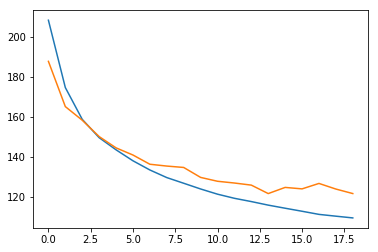

In [53]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error

def compute_error(left_eye_data, face_features_data, Ydata):
    y_true = Ydata
#     y_pred = model2.predict([left_eye_data, face_features_data[:,1:]]).astype(int)
#     error = rmse(y_true, y_pred)
#     print(error)
#     return error

#     # load
#     json_file = open('model.json', 'r')
#     loaded_model_json = json_file.read()
#     json_file.close()
#     loaded_model = model_from_json(loaded_model_json)
#     # load weights into new model
#     loaded_model.load_weights("model.h5")
#     print("Loaded model from disk")

#     # evaluate loaded model on test data
#     loaded_model.compile(loss='mae', optimizer='adam')
    scores = model2.evaluate([left_eye_data, np.concatenate((face_features_data[:,1:8],face_features_data[:,9:15]),axis = 1)], Ydata)
    return scores

In [ ]:
train_error = compute_error(train_left_eye_data, train_face_features_data, train_Ydata)
val_error = compute_error(val_left_eye_data, val_face_features_data, val_Ydata)
test_error = compute_error(test_left_eye_data, test_face_features_data, test_Ydata)
    
print("Train Error ==> ", train_error)
print("Val Error ==> ",  val_error)
print("Test Error ==> " ,test_error)

In [ ]:
import copy
model3 = copy.copy(model2)

In [ ]:
def get_shape(x,y,m,n):
    
    print(x.shape, y.shape, m.shape, n.shape)
    x1 = x.reshape((x.shape[0]*x.shape[1], x.shape[2], x.shape[3], x.shape[4]))
    y1 = y.reshape((y.shape[0]*y.shape[1], y.shape[2], y.shape[3], y.shape[4]))
    
    m1 = m.reshape((m.shape[0]*m.shape[1], m.shape[2]))
    n1 = n.reshape((n.shape[0]*n.shape[1], n.shape[2]))
    
    return x1,y1,m1,n1

In [ ]:
import copy
def after_calibration(model2, left_eye_data12, right_eye_data12, face_features_data12, Ydata12 ):
    train_error = []; val_error = []; test_error = []
    
    for i in range(len(left_eye_data12)):
        #model3 = copy.copy(model31)
        
        leye, reye, ff, Y = get_shape(left_eye_data12[i], right_eye_data12[i], face_features_data12[i], Ydata12[i])
        train_leye, train_reye, train_ff, train_Y = leye[:1000], reye[:1000], ff[:1000], Y[:1000]
        test_leye, test_reye, test_ff, test_Y = leye[1000:], reye[1000:], ff[1000:], Y[1000:]
        
        model2.fit([train_leye, np.concatenate((train_ff[:,1:8],train_ff[:,9:15]), axis =1)],train_Y, 
                     epochs=20, batch_size=40, verbose=0, shuffle= True)
            
        #y_pred = model2.predict([test_leye, np.concatenate((test_ff[:,1:8], test_ff[:,8:15]), axis=1).astype(int)])
        tr_s = model2.evaluate([train_leye, np.concatenate((train_ff[:,1:8],train_ff[:,9:15]),axis = 1)], train_Y)
        t_s = model2.evaluate([test_leye, np.concatenate((test_ff[:,1:8],test_ff[:,9:15]),axis = 1)], test_Y)
            
        train_error.append(tr_s)
        test_error.append(t_s)
        
        print(tr_s, t_s, "\n")
    return np.mean(train_error), np.mean(test_error)
    

In [ ]:
# users = [2,3,5,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
# left_eye_data12, right_eye_data12, face_features_data12, Ydata12 = get_data2(users)
# print(len(left_eye_data12), len(right_eye_data12), len(face_features_data12),len(Ydata12))

In [ ]:
tr, t = after_calibration(model3,left_eye_data12, right_eye_data12, face_features_data12, Ydata12 )
print(tr, t)

## Plot dataset

In [ ]:
def plot_data(folder, i, model2, n):
    
    filenameX = "/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/explicit_face_features_game/sample"+str(i+1)
    filenameX_face_points = "/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/explicit_face_points/sample_"+str(i+1)
    filenameY= "/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/original_road_view/sample_"+str(i+1)+".npy"
        
        
    video = "/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/original_road_view/sample_"+str(i+1)+".avi"
    driver_video = "/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/driver_view/sample_"+str(i+1)+".avi"
    
#     folderX = "/ssd_scratch/cvit/isha2/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/explicit_face_features_game/sample"+str(i+1)
    
#     folderY = "/ssd_scratch/cvit/isha2/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/original_road_view/sample_"+str(i+1)+".npy"
        
    leye = filenameX +"_left_eye_data.npy"
    reye = filenameX +"_right_eye_data.npy"
    headpose_pupil = filenameX +"_headpose_pupil.npy"
    face_points = filenameX_face_points +"_face_points.npy"

    if(os.path.exists(filenameY) and os.path.exists(leye) and os.path.exists(reye) and 
       os.path.exists(headpose_pupil) and os.path.exists(video)):
    
        x_lefteye = np.load(leye)
        x_righteye = np.load(reye)
        x_face_features = np.load(headpose_pupil)
        x_face_points = np.load(face_points)
        y = np.load(filenameY)
            
        if(y.shape[0] >= n):
           # print(i,'y')
            arrX_lefteye = x_lefteye[:n]
            arrX_righteye = x_righteye[:n]
            arrX_face_features = np.concatenate((x_face_features[:50], x_face_points[:50]),axis =1)
            
            if(i >= 9):
                arrY = get_value(y[:n,:])
            else:
                arrY = y[:n,:]
        
            # print(arrX_lefteye.shape, arrX_righteye.shape, arrX_face_features.shape)
            y_pred = model2.predict([arrX_lefteye, np.concatenate((arrX_face_features[:,1:8], arrX_face_features[:,8:15]), axis=1).astype(int)])
        
          #  print(arrY.shape, y_pred.shape)
            cap1 = cv2.VideoCapture(video)###### driver ###################
            
            plt.figure()
            for i in range(int(n/2)):
                ret,frame = cap1.read()
            #frame  = cv2.resize(frame, (250,250))
           # print(folder,i)
#             plt.figure()

            
            plt.imshow(frame)
            plt.scatter(arrY[i,0], arrY[i,1], c='g', s=150)
            plt.scatter(y_pred[i,0], y_pred[i,1], c='r', s=150)


#             plt.imshow(frame)
#             plt.scatter(arrY[int(n/2),0], arrY[int(n/2),1], c='g', s=150)
#             plt.scatter(y_pred[int(n/2),0], y_pred[int(n/2),1], c='r', s=150)
 


    
    


In [ ]:
def plot_data2(folder, i, model2, n):
    
    filenameX = "/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/explicit_face_features_game/sample"+str(i+1)
    filenameX_face_points = "/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/explicit_face_points/sample_"+str(i+1)
    filenameY= "/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/original_road_view/sample_"+str(i+1)+".npy"
        
        
    video = "/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/original_road_view/sample_"+str(i+1)+".avi"
    driver_video = "/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/driver_view/sample_"+str(i+1)+".avi"
    
#     folderX = "/ssd_scratch/cvit/isha2/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/explicit_face_features_game/sample"+str(i+1)
    
#     folderY = "/ssd_scratch/cvit/isha2/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/original_road_view/sample_"+str(i+1)+".npy"
        
    leye = filenameX +"_left_eye_data.npy"
    reye = filenameX +"_right_eye_data.npy"
    headpose_pupil = filenameX +"_headpose_pupil.npy"
    face_points = filenameX_face_points +"_face_points.npy"

    if(os.path.exists(filenameY) and os.path.exists(leye) and os.path.exists(reye) and 
       os.path.exists(headpose_pupil) and os.path.exists(video)):
    
        x_lefteye = np.load(leye)
        x_righteye = np.load(reye)
        x_face_features = np.load(headpose_pupil)
        x_face_points = np.load(face_points)
        y = np.load(filenameY)
            
        if(y.shape[0] >= n):
           # print(i,'y')
            arrX_lefteye = x_lefteye[:n]
            arrX_righteye = x_righteye[:n]
            arrX_face_features = np.concatenate((x_face_features[:50], x_face_points[:50]),axis =1)
            
            if(i >= 9):
                arrY = get_value(y[:n,:])
            else:
                arrY = y[:n,:]
        
            # print(arrX_lefteye.shape, arrX_righteye.shape, arrX_face_features.shape)
            y_pred = model2.predict([arrX_lefteye, np.concatenate((arrX_face_features[:,1:8], arrX_face_features[:,9:15]), axis=1).astype(int)])
        
          #  print(arrY.shape, y_pred.shape)
            cap1 = cv2.VideoCapture(video)###### driver ###################
            cap2 = cv2.VideoCapture(driver_video)###### driver ###################
            

            for i in range(int(n/2)):
                ret,frame = cap1.read()
                ret1, frame1 = cap2.read()
                
           # frame_array = np.concatenate((frame1, frame), axis =1)
            frame_array = frame1
            cv2.circle(frame,(arrY[int(n/2),0], arrY[int(n/2),1]), 70, (0,255,0), -1 )
            frame_array =  np.concatenate((frame_array, frame), axis =1)
            cv2.circle(frame,(y_pred[int(n/2),0], y_pred[int(n/2),1]), 70, (0,0,255), -1 )
            frame_array =  np.concatenate((frame_array, frame), axis =1)
            
            cap1 = cv2.VideoCapture(video)###### driver ###################
            cap2 = cv2.VideoCapture(driver_video)###### driver ###################
            
            ret,frame = cap1.read()
            
            for j in range(n):
                cv2.circle(frame,(arrY[j,0], arrY[j,1]), 70, (0,255,0), -1 )
                cv2.circle(frame,(y_pred[j,0], y_pred[j,1]), 70, (0,0,255), -1 )
 
            frame_array =  np.concatenate((frame_array, frame), axis =1)
    
                
#             plt.figure(figsize=(20,10))
#             plt.imshow(frame_array)
#             plt.show()
    
    
    
            model2.fit([arrX_lefteye[:1000], np.concatenate((arrX_face_features[:1000,1:8],arrX_face_features[:1000,9:15]), axis =1)],arrY, 
                     epochs=20, batch_size=40, verbose=0, shuffle= True)
            
            y_pred = model2.predict([arrX_lefteye, np.concatenate((arrX_face_features[:,1:8], arrX_face_features[:,9:15]), axis=1).astype(int)])
        
            
          #  print(arrY.shape, y_pred.shape)
            cap1 = cv2.VideoCapture(video)###### driver ###################
            cap2 = cv2.VideoCapture(driver_video)###### driver ###################
            
            ret,frame = cap1.read()
            
            for j in range(n):
                cv2.circle(frame,(arrY[j,0], arrY[j,1]), 70, (0,255,0), -1 )
                cv2.circle(frame,(y_pred[j,0], y_pred[j,1]), 70, (0,0,255), -1 )
 
            frame_array =  np.concatenate((frame_array, frame), axis =1)
            frame_array = cv2.resize(frame_array, (int(frame_array.shape[1]/4), int(frame_array.shape[0]/4)))
            print(frame_array.shape)
                
            plt.figure(figsize=(20,10))
            plt.axis('off')
            plt.imshow(frame_array)
            plt.show()
    
    
            

            return frame_array
    


In [ ]:
# def plot_data3(users, i, model2, n):
    
#     plt.figure()
#     for k in range(len(users)):
#         folder = users[k]
        
#         filenameX = "/ssd_scratch/cvit/isha2/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/explicit_face_features_game/sample"+str(i+1)
#         filenameX_face_points = "/ssd_scratch/cvit/isha2/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/explicit_face_points/sample_"+str(i+1)
#         filenameY= "/ssd_scratch/cvit/isha2/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/original_road_view/sample_"+str(i+1)+".npy"


#         video = "/ssd_scratch/cvit/isha2/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/original_road_view/sample_"+str(i+1)+".avi"
#         driver_video = "/ssd_scratch/cvit/isha2/DGM_final2/dataset_samples_callibrated/user"+str(folder)+"/driver_view/sample_"+str(i+1)+".avi"
      
#         leye = filenameX +"_left_eye_data.npy"
#         reye = filenameX +"_right_eye_data.npy"
#         headpose_pupil = filenameX +"_headpose_pupil.npy"
#         face_points = filenameX_face_points +"_face_points.npy"

#         if(os.path.exists(filenameY) and os.path.exists(leye) and os.path.exists(reye) and 
#            os.path.exists(headpose_pupil) and os.path.exists(video)):

#             x_lefteye = np.load(leye)
#             x_righteye = np.load(reye)
#             x_face_features = np.load(headpose_pupil)
#             x_face_points = np.load(face_points)
#             y = np.load(filenameY)

#             if(y.shape[0] >= n):
#                # print(i,'y')
#                 arrX_lefteye = x_lefteye[:n]
#                 arrX_righteye = x_righteye[:n]
#                 arrX_face_features = np.concatenate((x_face_features[:50], x_face_points[:50]),axis =1)

#                 if(i >= 9):
#                     arrY = get_value(y[:n,:])
#                 else:
#                     arrY = y[:n,:]

#                 # print(arrX_lefteye.shape, arrX_righteye.shape, arrX_face_features.shape)
#                 y_pred = model2.predict([arrX_lefteye, np.concatenate((arrX_face_features[:,1:8], arrX_face_features[:,8:15]), axis=1).astype(int)])

#               #  print(arrY.shape, y_pred.shape)
#                 cap1 = cv2.VideoCapture(video)###### driver ###################

#                 cv2.circle(frame,(arrY[int(n/2),0], arrY[int(n/2),1]), 150, (0,255,0), -1 )
#                 cv2.circle(frame,(y_pred[int(n/2),0], y_pred[int(n/2),1]), 150, (0,0,255), -1 )
                
#                 frame = cv2.resize(frame, (int(frame.shape[0]/10), int(frame.shape[1]/10)))
#                 print(frame.shape)
           
#        # plt.figure()
#         plt.axis('off')
#         plt.imshow(frame)
#         plt.show()



    


In [ ]:
# # frame_array = plot_data2(users[0],50,model2,50)
# frame_array = plot_data3(users,50,model2,50)

In [ ]:
k =0
for j in range(10,100,10):
    k +=1
    image_name = 'qualitative_results'+str(k)+'.png'
    for i in range(8):
        frame_array = plot_data2(users[i],j+i,model2,50)
        if(i ==0):
            frame_array2 = frame_array
        else:
            frame_array2 = np.concatenate((frame_array2, frame_array), axis =0)
    cv2.imwrite(image_name, frame_array2)

In [ ]:
cv2.imwrite('qualitative_results7.png', frame_array2)

In [ ]:
frame_array2.shape

In [ ]:
# for j in range(10):
#     for i in range(112):
#       #  plt.figure()
#       #  print(users[j],i)
#         plot_data(users[j],i,model2,50)
#     #break

# for j in range(20):
#     i = 50
#     plot_data(users[j],i,model2,50)
